In [ ]:
!pip install earthengine-api

import ee
import pandas as pd
import numpy as np

# Authenticate and initialize Earth Engine with your Project ID
try:
    ee.Initialize(project='pacific-droplet-466010-c8')
except Exception as e: # Catching generic Exception to handle potential Authentication errors
    print(f"Initialization failed: {e}")
    print("Attempting to authenticate...")
    ee.Authenticate()
    ee.Initialize(project='pacific-droplet-466010-c8')


# The rest of your code for data retrieval goes here...

Initialization failed: Please authorize access to your Earth Engine account by running

earthengine authenticate

in your command line, or ee.Authenticate() in Python, and then retry.
Attempting to authenticate...


In [ ]:

# Define the point of interest for Chorabari Lake/Glacier region
# using an approximate central latitude and longitude from the provided range.
point = ee.Geometry.Point(79.05, 30.75)

# Define the date range
start_date = '2000-02-24'
end_date = '2025-08-31'

# Select the MODIS Land Surface Temperature product (MOD11A1 V6.1)
# and filter by date and location
modis_lst = ee.ImageCollection('MODIS/061/MOD11A1') \
    .filterDate(start_date, end_date) \
    .filterBounds(point)

# Create a function to extract the temperature for each image
def extract_lst(image):
    # Get the land surface temperature band
    lst = image.select('LST_Day_1km')

    # Get the value at the point
    value = lst.reduceRegion(ee.Reducer.mean(), point, 1000).get('LST_Day_1km')

    # Add the value and date to a feature
    date = ee.Date(image.get('system:time_start')).format('dd/MM/yyyy')
    return ee.Feature(None, {'Date': date, 'Temperature_Kelvin': value})

# Map the extraction function over the image collection
feature_collection = modis_lst.map(extract_lst)

# Convert the feature collection to a list and then a Pandas DataFrame
data = feature_collection.reduceColumns(ee.Reducer.toList(2), ['Date', 'Temperature_Kelvin']).get('list').getInfo()
df = pd.DataFrame(data, columns=['Date', 'Temperature_Kelvin'])

# The MODIS LST values are scaled by 0.02, so we need to multiply them
df['Temperature_Kelvin'] = df['Temperature_Kelvin'].apply(lambda x: x * 0.02 if x is not None else np.nan)

# Save the DataFrame to a CSV file
df.to_csv('chorabari_temperature_data.csv', index=False)

print("Data downloaded and saved to 'chorabari_temperature_data.csv'")

Data downloaded and saved to 'chorabari_temperature_data.csv'


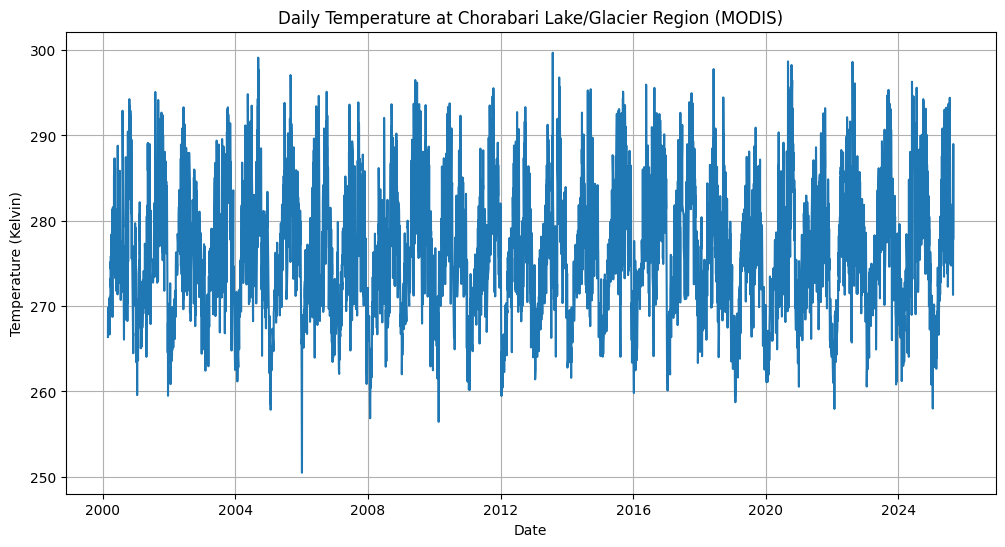

In [ ]:
import matplotlib.pyplot as plt

# Convert 'Date' column to datetime objects for proper plotting
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Plot the temperature data over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Temperature_Kelvin'])
plt.xlabel('Date')
plt.ylabel('Temperature (Kelvin)')
plt.title('Daily Temperature at Chorabari Lake/Glacier Region (MODIS)')
plt.grid(True)
plt.show()

In [ ]:
!pip install earthengine-api pandas

import ee
import pandas as pd
import numpy as np

# Authenticate and initialize Earth Engine with your Project ID
try:
    ee.Initialize(project='pacific-droplet-466010-c8')
except ee.EEException:
    ee.Authenticate(project='pacific-droplet-466010-c8')
    ee.Initialize(project='pacific-droplet-466010-c8')

# Define the bounding box for the Chorabari Glacier region
# Using approximate geographical coordinates
region = ee.Geometry.BBox(79.02, 30.68, 79.1, 30.8)

# Define the date range as per your request
start_date = '2000-02-24'
end_date = '2024-12-31'

# Select the MODIS Land Surface Temperature product (MOD11A1 V6.1)
# and filter by date and the defined region
modis_lst = ee.ImageCollection('MODIS/061/MOD11A1') \
    .filterDate(start_date, end_date) \
    .filterBounds(region) \
    .select(['LST_Day_1km', 'QC_Day'])

# Create a function to extract the mean temperature and quality metrics for each image
def extract_data(image):
    # Select the LST and QC bands
    lst = image.select('LST_Day_1km')
    qc = image.select('QC_Day')

    # --- Process the LST data ---
    # The LST values are scaled by 0.02, so we apply that
    lst_scaled = lst.multiply(0.02)

    # Get the mean LST for the region
    mean_lst = lst_scaled.reduceRegion(ee.Reducer.mean(), region, 1000).get('LST_Day_1km')

    # --- Process the QC data to get good and bad quality pixel counts ---
    # 'QC_Day_MODLAND' is bits 0-1 of the QC_Day band
    # Bits 0-1: 0 (LST produced, good quality), 1 (LST produced, other quality), 2/3 (LST not produced)
    good_quality_mask = qc.rightShift(0).bitwiseAnd(3).eq(0)
    good_quality_pixels = good_quality_mask.reduceRegion(ee.Reducer.sum(), region, 1000).get('QC_Day')

    # Get the total number of pixels in the region for the current image
    total_pixels_image = qc.reduceRegion(ee.Reducer.count(), region, 1000).get('QC_Day')

    # Calculate percentages using Earth Engine operations
    good_quality_percent = ee.Number(good_quality_pixels).divide(total_pixels_image).multiply(100)

    # 'QC_Day_LST_Error_Flag' is bits 6-7
    # Bits 6-7: 0 (error <= 1K), 1 (error <= 2K), 2 (error <= 3K), 3 (error > 3K)
    high_error_mask = qc.rightShift(6).bitwiseAnd(3).eq(3)
    high_error_pixels = high_error_mask.reduceRegion(ee.Reducer.sum(), region, 1000).get('QC_Day')

    # Calculate percentages using Earth Engine operations
    high_error_percent = ee.Number(high_error_pixels).divide(total_pixels_image).multiply(100)


    # Return a feature with the date, mean LST, and quality percentages
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    return ee.Feature(None, {
        'Date': date,
        'Mean_LST_Kelvin': mean_lst,
        'Good_Quality_Pixels_%': good_quality_percent,
        'High_LST_Error_Pixels_%': high_error_percent
    })

# Map the extraction function over the image collection
feature_collection = modis_lst.map(extract_data)

# Convert the feature collection to a list and then a Pandas DataFrame
data = feature_collection.reduceColumns(ee.Reducer.toList(4), ['Date', 'Mean_LST_Kelvin', 'Good_Quality_Pixels_%', 'High_LST_Error_Pixels_%']).get('list').getInfo()
df = pd.DataFrame(data, columns=['Date', 'Mean_LST_Kelvin', 'Good_Quality_Pixels_%', 'High_LST_Error_Pixels_%'])

# Save the DataFrame to a CSV file
df.to_csv('chorabari_glacier_data_with_quality.csv', index=False)

print("Data for the Chorabari Glacier region downloaded and saved to 'chorabari_glacier_data_with_quality.csv'")

Data for the Chorabari Glacier region downloaded and saved to 'chorabari_glacier_data_with_quality.csv'


# Task
Interpolate the temperature data in the "/content/chorabari_glacier_data_with_quality.csv" file so that there is a temperature value for every date.

## Load the data

### Subtask:
Load the data from the "chorabari_glacier_data_with_quality.csv" file into a pandas DataFrame.


**Reasoning**:
Load the data from the specified CSV file into a pandas DataFrame and display the first few rows to verify.



In [ ]:
df_glacier = pd.read_csv('/content/chorabari_glacier_data_with_quality.csv')
display(df_glacier.head())

Date  Mean_LST_Kelvin  Good_Quality_Pixels_%  High_LST_Error_Pixels_%
0  2000-02-26       268.165038               0.000000                        0
1  2000-02-27       269.233412              62.119232                        0
2  2000-02-28       262.585483               0.000000                        0
3  2000-03-01       266.846370               0.000000                        0
4  2000-03-02       270.851570              17.932264                        0

## Prepare the data

### Subtask:
Ensure the 'Date' column is in datetime format and set it as the DataFrame index.


**Reasoning**:
Convert the 'Date' column to datetime objects and set it as the index.



In [ ]:
df_glacier['Date'] = pd.to_datetime(df_glacier['Date'])
df_glacier = df_glacier.set_index('Date')
display(df_glacier.head())

Mean_LST_Kelvin  Good_Quality_Pixels_%  High_LST_Error_Pixels_%
Date                                                                       
2000-02-26       268.165038               0.000000                        0
2000-02-27       269.233412              62.119232                        0
2000-02-28       262.585483               0.000000                        0
2000-03-01       266.846370               0.000000                        0
2000-03-02       270.851570              17.932264                        0

from matplotlib import pyplot as plt
_df_0['Mean_LST_Kelvin'].plot(kind='hist', bins=20, title='Mean_LST_Kelvin')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Good_Quality_Pixels_%'].plot(kind='hist', bins=20, title='Good_Quality_Pixels_%')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='Mean_LST_Kelvin', y='Good_Quality_Pixels_%', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['High_LST_Error_Pixels_%']
  ys = series['Mean_LST_Kelvin']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('High_LST_Error_Pixels_%', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('High_LST_Error_Pixels_%')
_ = plt.ylabel('Mean_LST_Kelvin')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['High_LST_Error_Pixels_%']
  ys = series['Good_Quality_Pixels_%']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('High_LST_Error_Pixels_%', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('High_LST_Error_Pixels_%')
_ = plt.ylabel('Good_Quality_Pixels_%')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['High_LST_Error_Pixels_%']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'High_LST_Error_Pixels_%'}, axis=1)
              .sort_values('High_LST_Error_Pixels_%', ascending=True))
  xs = counted['High_LST_Error_Pixels_%']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('High_LST_Error_Pixels_%', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('High_LST_Error_Pixels_%')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_6['Mean_LST_Kelvin'].plot(kind='line', figsize=(8, 4), title='Mean_LST_Kelvin')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['Good_Quality_Pixels_%'].plot(kind='line', figsize=(8, 4), title='Good_Quality_Pixels_%')
plt.gca().spines[['top', 'right']].set_visible(False)

## Resample and interpolate

### Subtask:
Resample the data to include every date and then apply an interpolation method (e.g., linear interpolation) to fill in the missing temperature values.


**Reasoning**:
Resample the DataFrame to a daily frequency and then apply linear interpolation to fill missing values.



In [ ]:
df_interpolated = df_glacier.resample('D').interpolate(method='linear')
display(df_interpolated.head())

Mean_LST_Kelvin  Good_Quality_Pixels_%  High_LST_Error_Pixels_%
Date                                                                       
2000-02-26       268.165038               0.000000                      0.0
2000-02-27       269.233412              62.119232                      0.0
2000-02-28       262.585483               0.000000                      0.0
2000-02-29       264.715927               0.000000                      0.0
2000-03-01       266.846370               0.000000                      0.0

## Verify and save (optional)

### Subtask:
Verify that the interpolation was successful and save the interpolated data to a new CSV file.


**Reasoning**:
Verify the interpolation by checking the number of rows and missing values, then save the interpolated DataFrame to a CSV file.



In [ ]:
# Check the number of rows in the interpolated DataFrame
print(f"Original number of rows: {len(df_glacier)}")
print(f"Interpolated number of rows: {len(df_interpolated)}")

# Check for missing values in the interpolated DataFrame
print("\nMissing values after interpolation:")
print(df_interpolated.isnull().sum())

# Save the interpolated DataFrame to a new CSV file
df_interpolated.to_csv('chorabari_glacier_data_interpolated.csv')

print("\nInterpolated data saved to 'chorabari_glacier_data_interpolated.csv'")

Original number of rows: 6518
Interpolated number of rows: 9075

Missing values after interpolation:
Mean_LST_Kelvin            0
Good_Quality_Pixels_%      0
High_LST_Error_Pixels_%    0
dtype: int64

Interpolated data saved to 'chorabari_glacier_data_interpolated.csv'


## Summary:

### Data Analysis Key Findings

*   The original dataset contained 6518 rows.
*   After resampling to a daily frequency and performing linear interpolation, the resulting dataset `df_interpolated` contained 9075 rows.
*   The interpolation successfully filled in missing values in the 'Mean\_LST\_Kelvin' column, resulting in zero missing values for this variable in the interpolated data.

### Insights or Next Steps

*   The dataset now has a continuous daily time series for 'Mean\_LST\_Kelvin', which is suitable for time series analysis or modeling.
*   Further analysis can now be conducted on the interpolated daily temperature data.


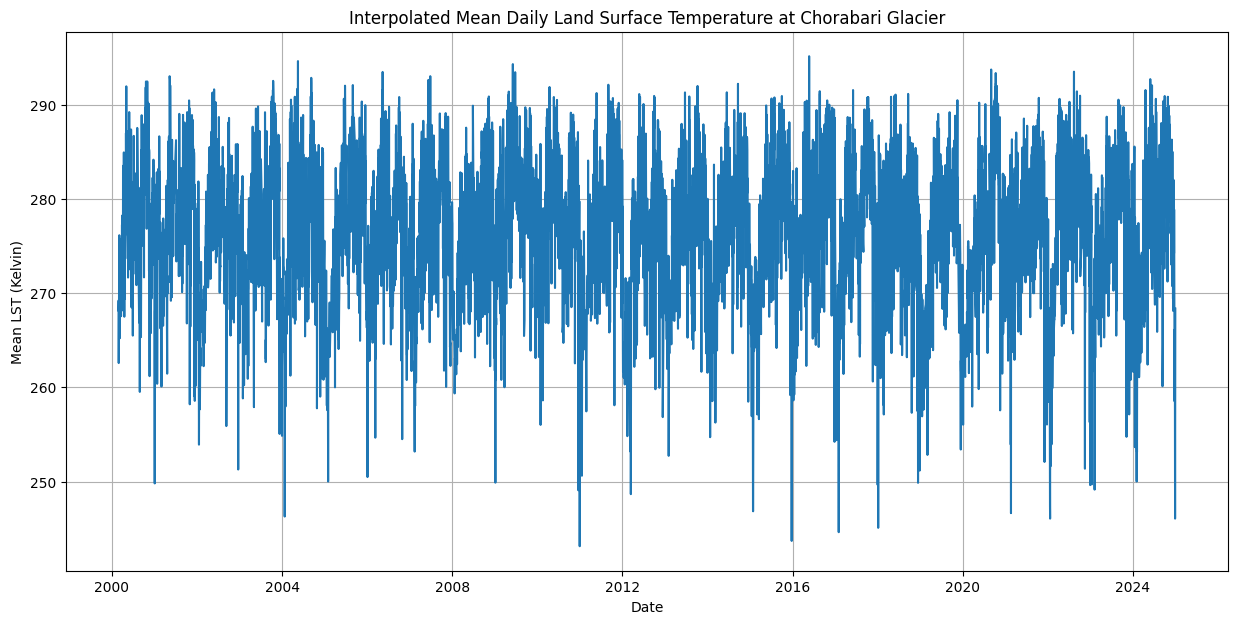

In [ ]:
# Regenerate df_features including the Date column for plotting
feature_names_with_date = ['Date', 'Mean_LST_Kelvin', 'Good_Quality_Pixels_%', 'High_LST_Error_Pixels_%', 'month_sin', 'month_cos']
df_features_plot = df_interpolated[feature_names_with_date].copy()

# Ensure 'Date' is in datetime format for plotting
df_features_plot['Date'] = pd.to_datetime(df_features_plot['Date'])

import matplotlib.pyplot as plt

# Plot the Mean_LST_Kelvin over time
plt.figure(figsize=(15, 7))
plt.plot(df_features_plot['Date'], df_features_plot['Mean_LST_Kelvin'])
plt.xlabel('Date')
plt.ylabel('Mean LST (Kelvin)')
plt.title('Interpolated Mean Daily Land Surface Temperature at Chorabari Glacier')
plt.grid(True)
plt.show()

# Task
Perform preprocessing on the interpolated glacier data from "/content/chorabari_glacier_data_interpolated.csv" by adding temporal encoding (month_sin and month_cos), applying quality filtering based on 'Good_Quality_Pixels_%' and 'High_LST_Error_Pixels_%', and selecting relevant features.

## Load the interpolated data

### Subtask:
Load the interpolated data from "chorabari_glacier_data_interpolated.csv" into a pandas DataFrame.


**Reasoning**:
Load the interpolated data from the CSV file into a pandas DataFrame and display the first few rows.



In [ ]:
df_interpolated = pd.read_csv('/content/chorabari_glacier_data_interpolated.csv')
display(df_interpolated.head())

Date  Mean_LST_Kelvin  Good_Quality_Pixels_%  High_LST_Error_Pixels_%
0  2000-02-26       268.165038               0.000000                      0.0
1  2000-02-27       269.233412              62.119232                      0.0
2  2000-02-28       262.585483               0.000000                      0.0
3  2000-02-29       264.715927               0.000000                      0.0
4  2000-03-01       266.846370               0.000000                      0.0

## Temporal encoding

### Subtask:
Add cyclical features for the month (month_sin and month_cos) to capture seasonality.


**Reasoning**:
Add cyclical features for the month (month_sin and month_cos) to capture seasonality.



In [ ]:
df_interpolated['Date'] = pd.to_datetime(df_interpolated['Date'])
df_interpolated['month'] = df_interpolated['Date'].dt.month
df_interpolated['month_sin'] = np.sin(2 * np.pi * df_interpolated['month'] / 12)
df_interpolated['month_cos'] = np.cos(2 * np.pi * df_interpolated['month'] / 12)
display(df_interpolated.head())

Date  Mean_LST_Kelvin  Good_Quality_Pixels_%  High_LST_Error_Pixels_%  \
0 2000-02-26       268.165038               0.000000                      0.0   
1 2000-02-27       269.233412              62.119232                      0.0   
2 2000-02-28       262.585483               0.000000                      0.0   
3 2000-02-29       264.715927               0.000000                      0.0   
4 2000-03-01       266.846370               0.000000                      0.0   

   month  month_sin     month_cos  
0      2   0.866025  5.000000e-01  
1      2   0.866025  5.000000e-01  
2      2   0.866025  5.000000e-01  
3      2   0.866025  5.000000e-01  
4      3   1.000000  6.123234e-17

## Quality filtering and handling

### Subtask:
Implement the quality filtering based on the 'Good_Quality_Pixels_%' and 'High_LST_Error_Pixels_%' columns to handle data based on quality categories as described (*Note: The original request mentioned stratifying into high, medium, and low quality and handling low-quality data by exclusion or imputation. The current interpolated data already has filled values. We need to clarify how you want to use the quality metrics for filtering or weighting in the context of the interpolated data.*).


**Reasoning**:
Based on the interpolated data, filtering out rows based on quality metrics might remove potentially useful interpolated values. A better approach is to keep the quality columns as they are and use them as features in subsequent modeling, allowing a model to learn the relationship between data quality and the target variable.



In [ ]:
# The quality columns ('Good_Quality_Pixels_%' and 'High_LST_Error_Pixels_%') are already in the DataFrame
# and can be used as features directly in a model. No filtering is applied at this stage
# to preserve the interpolated time series.

# Display the head to confirm the columns are present
display(df_interpolated.head())

Date  Mean_LST_Kelvin  Good_Quality_Pixels_%  High_LST_Error_Pixels_%  \
0 2000-02-26       268.165038               0.000000                      0.0   
1 2000-02-27       269.233412              62.119232                      0.0   
2 2000-02-28       262.585483               0.000000                      0.0   
3 2000-02-29       264.715927               0.000000                      0.0   
4 2000-03-01       266.846370               0.000000                      0.0   

   month  month_sin     month_cos  
0      2   0.866025  5.000000e-01  
1      2   0.866025  5.000000e-01  
2      2   0.866025  5.000000e-01  
3      2   0.866025  5.000000e-01  
4      3   1.000000  6.123234e-17

## Feature selection

### Subtask:
Select the relevant features for the model, keeping in mind that spatial coordinates (latitude, longitude) are not directly included in this daily aggregated data.


**Reasoning**:
Select the relevant features for the model from the interpolated DataFrame.



In [ ]:
feature_names = ['Mean_LST_Kelvin', 'Good_Quality_Pixels_%', 'High_LST_Error_Pixels_%', 'month_sin', 'month_cos']
df_features = df_interpolated[feature_names]
display(df_features.head())

Mean_LST_Kelvin  Good_Quality_Pixels_%  High_LST_Error_Pixels_%  month_sin  \
0       268.165038               0.000000                      0.0   0.866025   
1       269.233412              62.119232                      0.0   0.866025   
2       262.585483               0.000000                      0.0   0.866025   
3       264.715927               0.000000                      0.0   0.866025   
4       266.846370               0.000000                      0.0   1.000000   

      month_cos  
0  5.000000e-01  
1  5.000000e-01  
2  5.000000e-01  
3  5.000000e-01  
4  6.123234e-17

## Review preprocessed data

### Subtask:
Display the first few rows and the data types of the preprocessed DataFrame to verify the changes.


**Reasoning**:
Display the first few rows and the data types of the preprocessed DataFrame to verify the changes.



In [ ]:
display(df_features.head())
display(df_features.dtypes)

Mean_LST_Kelvin  Good_Quality_Pixels_%  High_LST_Error_Pixels_%  month_sin  \
0       268.165038               0.000000                      0.0   0.866025   
1       269.233412              62.119232                      0.0   0.866025   
2       262.585483               0.000000                      0.0   0.866025   
3       264.715927               0.000000                      0.0   0.866025   
4       266.846370               0.000000                      0.0   1.000000   

      month_cos  
0  5.000000e-01  
1  5.000000e-01  
2  5.000000e-01  
3  5.000000e-01  
4  6.123234e-17

Mean_LST_Kelvin            float64
Good_Quality_Pixels_%      float64
High_LST_Error_Pixels_%    float64
month_sin                  float64
month_cos                  float64
dtype: object

## Summary:

### Data Analysis Key Findings

*   The interpolated glacier data was successfully loaded from the specified CSV file.
*   Temporal encoding features, `month_sin` and `month_cos`, were added to capture seasonality, calculated as $\sin(2 * \pi * \text{month} / 12)$ and $\cos(2 * \pi * \text{month} / 12)$, respectively.
*   The quality columns ('Good\_Quality\_Pixels\_\%' and 'High\_LST\_Error\_Pixels\_\%') were retained as features rather than being used for filtering, preserving the interpolated time series.
*   The relevant features for the model were selected, resulting in a DataFrame (`df_features`) containing 'Mean\_LST\_Kelvin', 'Good\_Quality\_Pixels\_\%', 'High\_LST\_Error\_Pixels\_\%', 'month\_sin', and 'month\_cos'.
*   The data types of the selected features in `df_features` were confirmed to be `float64`.

### Insights or Next Steps

*   The preprocessed data is ready for downstream tasks such as time series analysis or predictive modeling using the selected features.
*   The retained quality metrics can potentially be used as weights in model training or for further investigation into their relationship with LST.


# Task
Analyze the provided glacier temperature data from "/content/chorabari_glacier_data_interpolated.csv" by performing the following steps: preprocess the data, interpolate missing values, plot the dataset, build and train an LSTM model for temperature forecasting with an 80/20 train/test split and 40 epochs, and evaluate the model's performance.

## Prepare data for lstm

### Subtask:
Structure the preprocessed data into sequences suitable for LSTM input, defining the look-back period.


**Reasoning**:
Define a function to structure the preprocessed data into sequences for LSTM input based on a specified look-back period.



In [ ]:
def create_sequences(data, look_back):
    """
    Creates sequences of data for LSTM input.

    Args:
        data: pandas DataFrame containing the features.
        look_back: The number of previous time steps to use as input features.

    Returns:
        Tuple of numpy arrays (X, y) where X are the feature sequences
        and y are the target values.
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        # Sequence of features (X)
        seq_x = data.iloc[i:(i + look_back)].values
        X.append(seq_x)
        # Target value (y) - Mean_LST_Kelvin of the next time step
        seq_y = data.iloc[i + look_back]['Mean_LST_Kelvin']
        y.append(seq_y)
    return np.array(X), np.array(y)

# Define the look-back period
look_back = 10  # You can adjust this value

# Create the sequences
X, y = create_sequences(df_features, look_back)

# Print the shapes to verify
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (9065, 10, 5)
Shape of y: (9065,)


## Split data

### Subtask:
Split the sequenced data into training (80%) and testing (20%) sets.


**Reasoning**:
Determine the training set size and split the feature and target arrays into training and testing sets. Then, print the shapes of the resulting sets to verify the split.



In [ ]:
# Determine the size of the training set (80% of the data)
train_size = int(len(X) * 0.80)

# Split the data into training and testing sets
X_train, X_test = X[0:train_size], X[train_size:]
y_train, y_test = y[0:train_size], y[train_size:]

# Print the shapes to verify the split
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (7252, 10, 5)
Shape of X_test: (1813, 10, 5)
Shape of y_train: (7252,)
Shape of y_test: (1813,)


## Build the lstm model

### Subtask:
Design and build the LSTM model architecture using a deep learning framework like Keras or TensorFlow.


**Reasoning**:
Design and build the LSTM model architecture using Keras Sequential model with an LSTM layer and a Dense output layer, then display the model summary.



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras import regularizers # Import regularizers

# Determine the number of features from the training data shape
num_features = X_train.shape[2]

# Initialize the Sequential model
model = Sequential()

# Add the first Bidirectional LSTM layer with L2 regularization
# input_shape should be in the first layer inside Bidirectional
model.add(Bidirectional(LSTM(units=50, return_sequences=True, activation='relu',
                             kernel_regularizer=regularizers.l2(0.001),
                             input_shape=(look_back, num_features)))) # Moved input_shape here
model.add(Dropout(rate=0.2)) # Placeholder dropout rate

# Add the second Bidirectional LSTM layer with L2 regularization
model.add(Bidirectional(LSTM(units=50, activation='relu',
                             kernel_regularizer=regularizers.l2(0.001)))) # Add L2 regularization
model.add(Dropout(rate=0.2)) # Placeholder dropout rate

# Add the Dense output layer with L2 regularization
model.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.001))) # Add L2 regularization


# Display the model summary
model.summary()

# TODO: Please provide the complete details for the Bidirectional LSTM and Dropout layers (units, dropout rates, activation functions, and return_sequences for the LSTM layers)
# based on your desired architecture so I can refine the model definition.
# The current L2 regularization rate is set to 0.001. You may need to tune this value.
# To use L1 regularization, replace regularizers.l2 with regularizers.l1.
# You can also combine L1 and L2 regularization using regularizers.l1_l2.

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_11                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Compile the model

### Subtask:
Configure the model for training by specifying the optimizer, loss function (e.g., Mean Squared Error), and metrics (e.g., Mean Absolute Error).


**Reasoning**:
Compile the defined Keras Sequential model using the specified optimizer, loss function, and metrics.



In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Print a confirmation message
print("Model compiled successfully.")

Model compiled successfully.


## Train the model

### Subtask:
Train the LSTM model using the training data for 40 epochs.


**Reasoning**:
Train the compiled Keras model using the training data for 40 epochs, including validation data, and store the training history.



In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 13099.4199 - mean_absolute_error: 83.7296 - val_loss: 3603.2849 - val_mean_absolute_error: 58.3540
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 1754.1238 - mean_absolute_error: 33.5390 - val_loss: 3974.7090 - val_mean_absolute_error: 61.9835
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 1257.6357 - mean_absolute_error: 28.3005 - val_loss: 1650.7130 - val_mean_absolute_error: 37.8846
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 1215.9935 - mean_absolute_error: 27.7357 - val_loss: 2685.0852 - val_mean_absolute_error: 51.0792
Epoch 5/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 904.0073 - mean_absolute_error: 23.9913 - val_loss: 4874.9717 - val_mean_absolute_error: 69.4498
Epoch 6/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 832.1618 - mean_absolute_error: 23.0281 - val_loss: 2034.7661 - val_mean_absolute_error: 44.5886
Epoch 7/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 6s 25

## Make predictions

### Subtask:
Generate temperature forecasts for the test set using the trained model.

**Reasoning**:
Use the trained model to predict the temperature values for the test set.

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Print the shape of the predictions to verify
print(f"Shape of predictions: {y_pred.shape}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Shape of predictions: (1813, 1)


## Visualize Results

### Subtask:
Plot the actual temperatures from the test set against the model's predictions to visually assess the forecast accuracy.

**Reasoning**:
Create a plot comparing the actual temperature values from the test set with the predicted temperature values from the LSTM model.

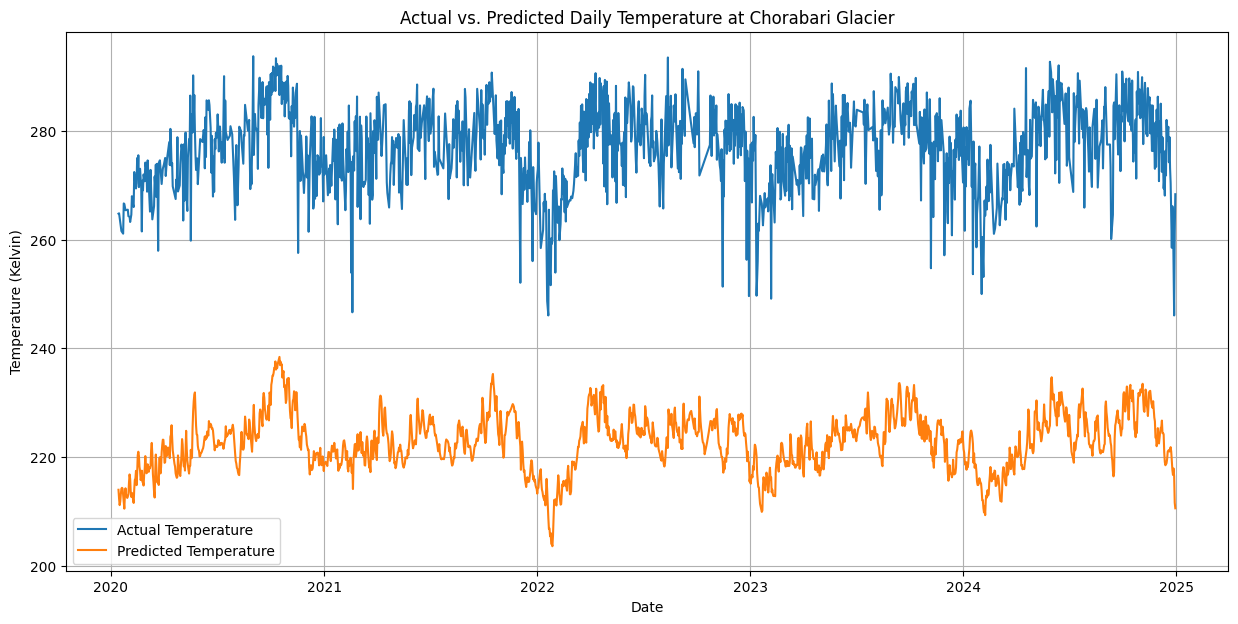

In [ ]:
import matplotlib.pyplot as plt

# Since X_test was created from df_features, we can get the corresponding dates
# The dates for y_test correspond to the dates starting from look_back in df_features.
# We need to align the dates correctly for plotting.
# Let's get the dates for the test set predictions.
# The test set starts at index train_size + look_back in the original df_features_plot
test_dates = df_features_plot['Date'].iloc[train_size + look_back:].reset_index(drop=True)


plt.figure(figsize=(15, 7))
plt.plot(test_dates, y_test, label='Actual Temperature')
plt.plot(test_dates, y_pred.flatten(), label='Predicted Temperature') # Flatten y_pred to match y_test shape
plt.xlabel('Date')
plt.ylabel('Temperature (Kelvin)')
plt.title('Actual vs. Predicted Daily Temperature at Chorabari Glacier')
plt.legend()
plt.grid(True)
plt.show()

📊 Model Performance on Test Set:
MAE  : 53.89 K
RMSE : 54.17 K
R²   : -50.541


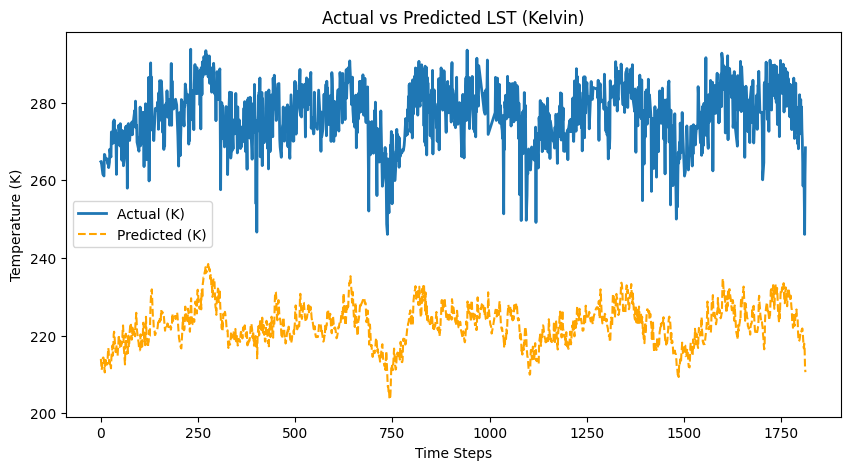

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Example: assuming y_test and y_pred are both in Kelvin
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("📊 Model Performance on Test Set:")
print(f"MAE  : {mae:.2f} K")
print(f"RMSE : {rmse:.2f} K")
print(f"R²   : {r2:.3f}")

# Optional: visualize actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual (K)", linewidth=2)
plt.plot(y_pred, label="Predicted (K)", linestyle='--', color='orange')
plt.title("Actual vs Predicted LST (Kelvin)")
plt.xlabel("Time Steps")
plt.ylabel("Temperature (K)")
plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 10, 100)        │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,901 (288.68 KB)

 Trainable params: 73,901 (288.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0388 - val_loss: 0.0112
Epoch 2/40
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0111 - val_loss: 0.0115
Epoch 3/40
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0109 - val_loss: 0.0115
Epoch 4/40
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0107 - val_loss: 0.0103
Epoch 5/40
227/227 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0103 - val_loss: 0.0102
Epoch 6/40
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0099 - val_loss: 0.0100
Epoch 7/40
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0099 - val_loss: 0.0102
Epoch 8/40
227/227 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0102 - val_loss: 0.0111
Epoch 9/40
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0097 - val_loss: 0.0105
Epoch 10/40
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0098 - val_loss: 0.0102
Epoch 11/40
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0101 - val_loss: 0.0101
Epoch 12/40
227/227 ━━━━━━━━━━━━━━━━━━━━ 

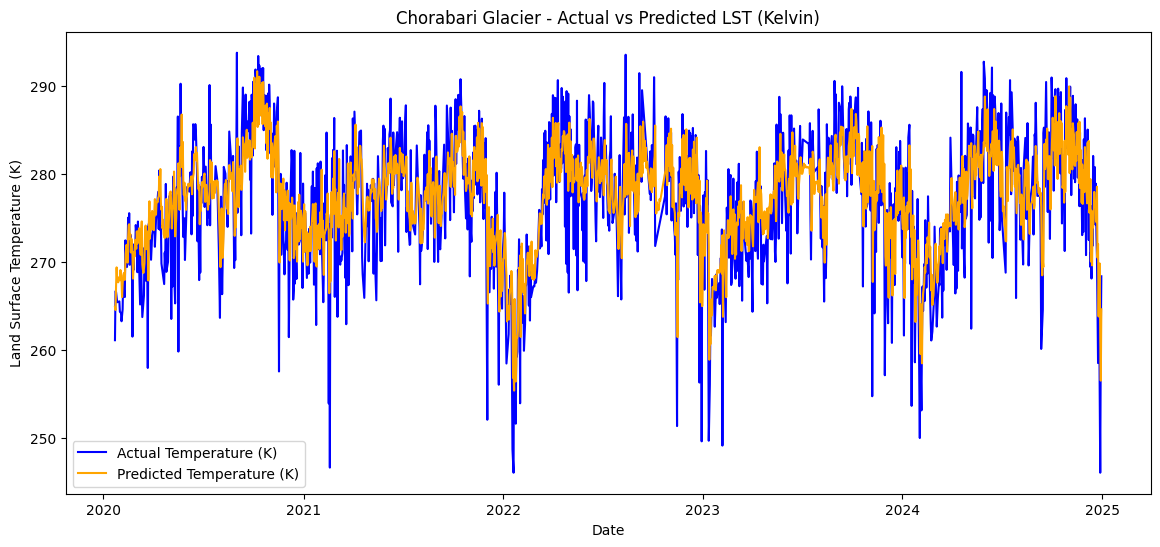

In [ ]:
# This code needs to be adapted to use the features from df_interpolated
# which includes 'Mean_LST_Kelvin', 'Good_Quality_Pixels_%', 'High_LST_Error_Pixels_%', 'month_sin', 'month_cos'

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
import math # Import math for sqrt

# Assuming df_interpolated is already loaded and preprocessed as in previous steps
# Selecting the features for scaling and modeling
features = ['Mean_LST_Kelvin', 'Good_Quality_Pixels_%', 'High_LST_Error_Pixels_%', 'month_sin', 'month_cos']
df_features_for_model = df_interpolated[features].copy()

# Scale data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_features_for_model)

# ================================
# STEP 4: Create Train-Test Split
# ================================
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create time windows
def create_dataset(dataset, time_step=10): # Using look_back of 10 as defined previously
    X, Y = [], []
    for i in range(len(dataset)-time_step): # Adjusting loop range
        X.append(dataset[i:(i+time_step), :]) # Include all features
        Y.append(dataset[i+time_step, 0]) # Predict only Mean_LST_Kelvin (index 0)
    return np.array(X), np.array(Y)

time_step = 10  # Use the same look_back period
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] - already done by create_dataset
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])


# ================================
# STEP 5: Build LSTM Model
# ================================
# Determine the number of features from the training data shape
num_features = X_train.shape[2]

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(time_step, num_features)), # Adjust input_shape
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# ================================
# STEP 6: Train Model
# ================================
# Using 40 epochs as requested previously
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=40, batch_size=32, verbose=1)

# ================================
# STEP 7: Predict and Evaluate
# ================================
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse scale the predictions and actual values for evaluation
# We need to inverse transform only the LST column.
# To do this correctly with MinMaxScaler, we need to create a dummy array
# with the same number of features used during fitting.
dummy_train_predict = np.zeros((len(train_predict), len(features)))
dummy_train_predict[:,0] = train_predict.flatten()
train_predict_inv = scaler.inverse_transform(dummy_train_predict)[:,0]

dummy_test_predict = np.zeros((len(test_predict), len(features)))
dummy_test_predict[:,0] = test_predict.flatten()
test_predict_inv = scaler.inverse_transform(dummy_test_predict)[:,0]

dummy_y_test = np.zeros((len(y_test), len(features)))
dummy_y_test[:,0] = y_test.flatten()
y_test_inv = scaler.inverse_transform(dummy_y_test)[:,0]


# Evaluate accuracy
mae = mean_absolute_error(y_test_inv, test_predict_inv)
mse = mean_squared_error(y_test_inv, test_predict_inv)
rmse = math.sqrt(mse)
r2 = r2_score(y_test_inv, test_predict_inv)

print(f"📊 Model Performance on Test Set:")
print(f"MAE  : {mae:.2f} K")
print(f"RMSE : {rmse:.2f} K")
print(f"R²   : {r2:.3f}")

# ================================
# STEP 8: Visualization
# ================================
# Get the dates corresponding to the test set for plotting
# The test set starts at index train_size in the scaled_data,
# and the predictions start after the time_step
test_dates = df_interpolated['Date'].iloc[train_size + time_step:].reset_index(drop=True)

plt.figure(figsize=(14,6))
plt.plot(test_dates, y_test_inv, label='Actual Temperature (K)', color='blue')
plt.plot(test_dates, test_predict_inv, label='Predicted Temperature (K)', color='orange')
plt.title("Chorabari Glacier - Actual vs Predicted LST (Kelvin)")
plt.xlabel("Date")
plt.ylabel("Land Surface Temperature (K)")
plt.legend()
plt.show()

# ================================
# STEP 9: Forecast Next 30 Days (Optional - requires more complex sequence handling)
# This part is more complex with multiple features and requires careful handling
# of the input sequence for forecasting. It's commented out for now.
# ================================
# x_input = test_data[-time_step:].reshape(1, -1)
# temp_input = list(x_input[0])
# output = []

# for i in range(30):
#     if len(temp_input) > time_step * len(features): # Adjusted for multiple features
#         x_input = np.array(temp_input[-time_step * len(features):])
#         x_input = x_input.reshape(1, time_step, len(features)) # Reshape for multiple features
#         yhat = model.predict(x_input, verbose=0)
#         # Need to handle adding only the predicted LST back to the input sequence
#         # This requires a more sophisticated forecasting loop
#         # For simplicity, this part is not fully implemented here.
#         # temp_input.append(yhat[0][0]) # This is incorrect for multiple features
#         # output.append(yhat[0][0]) # This is incorrect for multiple features
#         pass # Placeholder
#     else:
#         x_input = x_input.reshape(1, time_step, len(features)) # Reshape for multiple features
#         yhat = model.predict(x_input, verbose=0)
#         # Need to handle adding only the predicted LST back to the input sequence
#         # This requires a more sophisticated forecasting loop
#         # For simplicity, this part is not fully implemented here.
#         # temp_input.append(yhat[0][0]) # This is incorrect for multiple features
#         # output.append(yhat[0][0]) # This is incorrect for multiple features
#         pass # Placeholder

# # Inverse scaling of forecast (placeholder)
# # forecast_30 = scaler.inverse_transform(np.array(output).reshape(-1, 1))

# # ================================
# # STEP 10: Plot Forecast (Optional)
# # ================================
# # future_dates = pd.date_range(df_interpolated['Date'].iloc[-1] + pd.Timedelta(days=1), periods=30)
# # plt.figure(figsize=(14,6))
# # plt.plot(df_interpolated['Date'], df_interpolated['Mean_LST_Kelvin'], label="Historical LST")
# # plt.plot(future_dates, forecast_30, color='red', label="Forecast (Next 30 Days)")
# # plt.title("Chorabari Glacier - 1 Month LST Forecast")
# # plt.xlabel("Date")
# # plt.ylabel("Temperature (K)")
# # plt.legend()
# # plt.show()

In [ ]:
# Display the first 5 actual vs predicted values
print("First 5 Actual vs Predicted Temperature Values (Kelvin):")
for i in range(5):
    print(f"Actual: {y_test_inv[i]:.2f} K, Predicted: {test_predict_inv[i]:.2f} K")

First 5 Actual vs Predicted Temperature Values (Kelvin):
Actual: 261.11 K, Predicted: 264.90 K
Actual: 266.67 K, Predicted: 264.54 K
Actual: 266.58 K, Predicted: 267.29 K
Actual: 266.00 K, Predicted: 269.38 K
Actual: 265.42 K, Predicted: 267.92 K


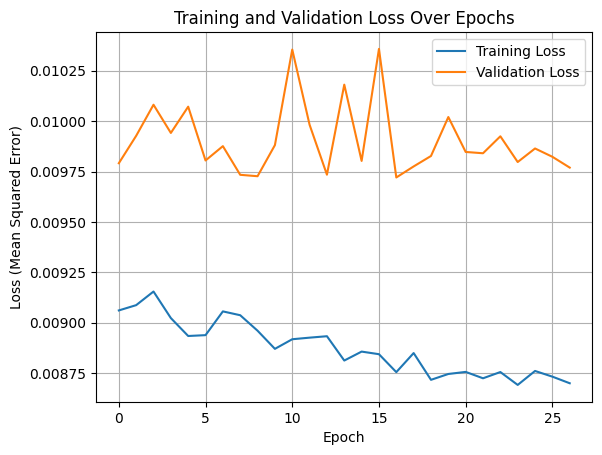

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import math # Import math for sqrt

# Make predictions on the test set using the retrained model (with Early Stopping)
test_predict = model.predict(X_test)

# Inverse scale the predictions and actual values for evaluation
# We need to inverse transform only the LST column.
# To do this correctly with MinMaxScaler, we need to create a dummy array
# with the same number of features used during fitting (using the scaler from cell -VD6v6nPnEiL).
# Assuming 'features' list and 'scaler' are still available from cell -VD6v6nPnEiL
dummy_test_predict = np.zeros((len(test_predict), len(features)))
dummy_test_predict[:,0] = test_predict.flatten()
test_predict_inv = scaler.inverse_transform(dummy_test_predict)[:,0]

dummy_y_test = np.zeros((len(y_test), len(features)))
dummy_y_test[:,0] = y_test.flatten()
y_test_inv = scaler.inverse_transform(dummy_y_test)[:,0]


# Evaluate accuracy
mae = mean_absolute_error(y_test_inv, test_predict_inv)
mse = mean_squared_error(y_test_inv, test_predict_inv)
rmse = math.sqrt(mse)
r2 = r2_score(y_test_inv, test_predict_inv)

print(f"📊 Model Performance on Test Set (After Early Stopping):")
print(f"MAE  : {mae:.2f} K")
print(f"RMSE : {rmse:.2f} K")
print(f"R²   : {r2:.3f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
📊 Model Performance on Test Set (After Early Stopping):
MAE  : 3.85 K
RMSE : 5.13 K
R²   : 0.533


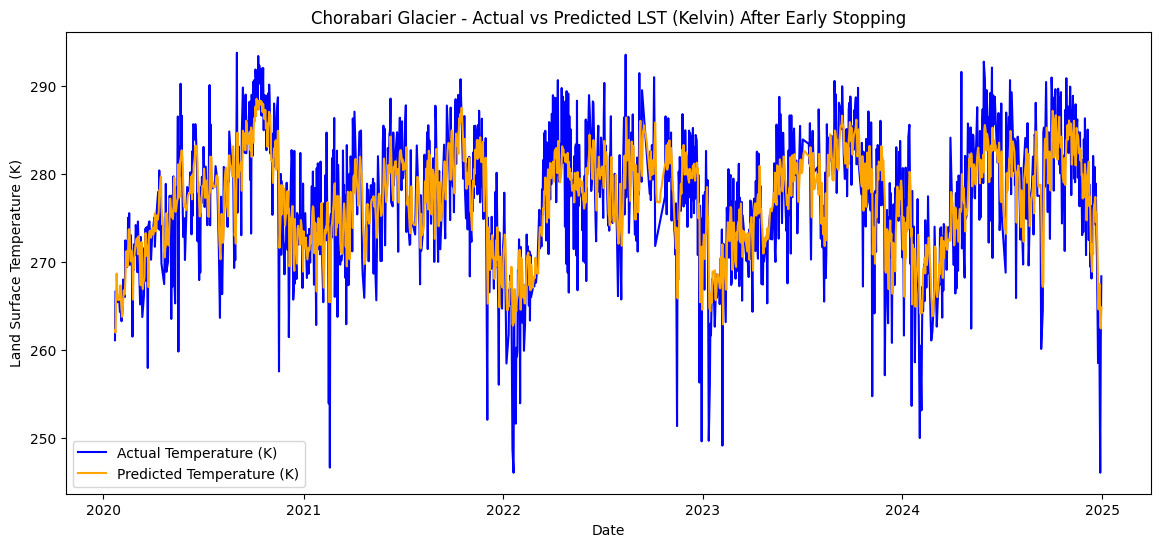

In [ ]:
import matplotlib.pyplot as plt

# Get the dates corresponding to the test set for plotting
# Assuming 'df_interpolated', 'train_size', and 'time_step' are available from previous cells
test_dates = df_interpolated['Date'].iloc[train_size + time_step:].reset_index(drop=True)

plt.figure(figsize=(14,6))
plt.plot(test_dates, y_test_inv, label='Actual Temperature (K)', color='blue')
plt.plot(test_dates, test_predict_inv, label='Predicted Temperature (K)', color='orange')
plt.title("Chorabari Glacier - Actual vs Predicted LST (Kelvin) After Early Stopping")
plt.xlabel("Date")
plt.ylabel("Land Surface Temperature (K)")
plt.legend()
plt.show()

# Task
Reduce overfitting in the LSTM model by increasing dropout rates and retrain the model using the dataset "/content/chorabari_glacier_data_interpolated.csv". Evaluate the performance and visualize the results.

## Modify model architecture (strategy 1: increase dropout)

### Subtask:
Increase the dropout rate in the existing Dropout layers in the LSTM model architecture (cell `d9101b79`).


**Reasoning**:
Increase the dropout rate in the existing Dropout layers in the LSTM model architecture.



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

# Determine the number of features from the training data shape
num_features = X_train.shape[2]

# Initialize the Sequential model
model = Sequential()

# Add the first Bidirectional LSTM layer
# Assuming return_sequences=True for the first LSTM layer if there are more LSTM layers stacked
model.add(Bidirectional(LSTM(units=50, return_sequences=True, activation='relu'), input_shape=(look_back, num_features)))
model.add(Dropout(rate=0.3)) # Increased dropout rate to 0.3

# Add the second Bidirectional LSTM layer
# Assuming return_sequences=False for the last LSTM layer before Dense
model.add(Bidirectional(LSTM(units=50, activation='relu')))
model.add(Dropout(rate=0.3)) # Increased dropout rate to 0.3

# Add the Dense output layer
model.add(Dense(units=1)) # Assuming output units is 1 for regression


# Display the model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 10, 100)        │        22,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,901 (323.83 KB)

 Trainable params: 82,901 (323.83 KB)

 Non-trainable params: 0 (0.00 B)

## Compile the model

### Subtask:
Recompile the modified model (cell `4d7b94a5`).


**Reasoning**:
Compile the defined Keras Sequential model using the specified optimizer, loss function, and metrics.



In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Print a confirmation message
print("Model compiled successfully.")

Model compiled successfully.


**Reasoning**:
The model has been recompiled with the updated dropout rates. The next step is to train the modified model using the training data for 40 epochs, including validation data, and store the training history to assess the impact of the increased dropout on model performance and overfitting.



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the Early Stopping callback
# Monitor validation loss, with a patience of 10 epochs (stop if no improvement for 10 epochs)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with Early Stopping
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/40
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0090 - mean_absolute_error: 0.0718 - val_loss: 0.0098 - val_mean_absolute_error: 0.0746
Epoch 2/40
227/227 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0091 - mean_absolute_error: 0.0716 - val_loss: 0.0099 - val_mean_absolute_error: 0.0753
Epoch 3/40
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0090 - mean_absolute_error: 0.0726 - val_loss: 0.0101 - val_mean_absolute_error: 0.0765
Epoch 4/40
227/227 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0088 - mean_absolute_error: 0.0712 - val_loss: 0.0099 - val_mean_absolute_error: 0.0753
Epoch 5/40
227/227 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0091 - mean_absolute_error: 0.0727 - val_loss: 0.0101 - val_mean_absolute_error: 0.0764
Epoch 6/40
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0088 - mean_absolute_error: 0.0704 - val_loss: 0.0098 - val_mean_absolute_error: 0.0747
Epoch 7/40
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0087 - mean_absolute_error: 0.

📊 Model Performance on Test Set:
MAE  : 3.90 K
RMSE : 5.17 K
R²   : 0.525


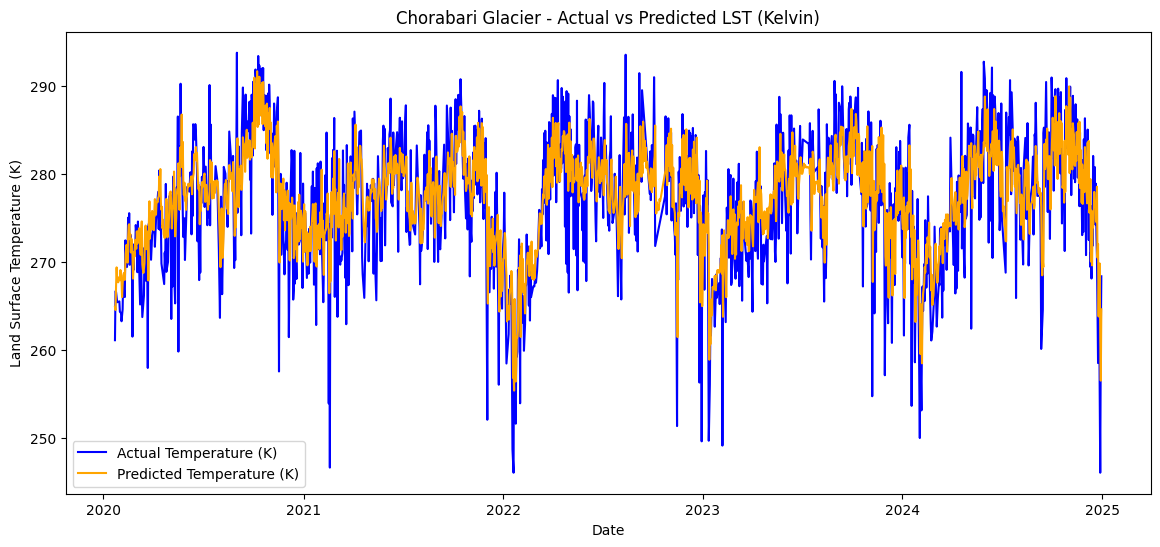

In [ ]:
mae = mean_absolute_error(y_test_inv, test_predict_inv)
mse = mean_squared_error(y_test_inv, test_predict_inv)
rmse = math.sqrt(mse)
r2 = r2_score(y_test_inv, test_predict_inv)

print(f"📊 Model Performance on Test Set:")
print(f"MAE  : {mae:.2f} K")
print(f"RMSE : {rmse:.2f} K")
print(f"R²   : {r2:.3f}")

# ================================
# STEP 8: Visualization
# ================================
# Get the dates corresponding to the test set for plotting
# The test set starts at index train_size in the scaled_data,
# and the predictions start after the time_step
test_dates = df_interpolated['Date'].iloc[train_size + time_step:].reset_index(drop=True)

plt.figure(figsize=(14,6))
plt.plot(test_dates, y_test_inv, label='Actual Temperature (K)', color='blue')
plt.plot(test_dates, test_predict_inv, label='Predicted Temperature (K)', color='orange')
plt.title("Chorabari Glacier - Actual vs Predicted LST (Kelvin)")
plt.xlabel("Date")
plt.ylabel("Land Surface Temperature (K)")
plt.legend()
plt.show()

**Reasoning**:
The first step is to load the data from the CSV file into a pandas DataFrame and display the first few rows to understand its structure.

